<a href="https://colab.research.google.com/github/camrobertson/FDA_SupplementModel/blob/master/FDA_sup_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ML analysis to predict timing/nature of supplements following BLA/NDA submission

Input from drugs@fda.com
Highlight variables BLA/NDA, Date of Submission,, Therapeutic Area (review division), priority review, breakthrough therapy, accelerated approval
See what happens (start w/ RFS)

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
!pip install sklearn
!pip install lifelines

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from google.colab import drive
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib as mpl #only needed to determine Matplotlib version number
import csv

     |████████████████████████████████| 337kB 4.7MB/s 
     |████████████████████████████████| 24.8MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
# Might be redundant w/ Cell #5
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Initialize Dataframe
Products_df = pd.DataFrame()
Submissions_df = pd.DataFrame()
Applications_df = pd.DataFrame()
Master_df = pd.DataFrame()
Original_df = pd.DataFrame()
Target_df = pd.DataFrame()

In [35]:
#works to import data
Products_df = pd.read_csv('/content/gdrive/My Drive/FDA_data/target/Products.txt', '\t', low_memory = False, error_bad_lines = False, encoding = "utf8")
Products_df.describe()
#Products_df

#works to import data
Submissions_df = pd.read_csv('/content/gdrive/My Drive/FDA_data/target/Submissions.txt', '\t', low_memory = False, error_bad_lines = False, encoding='ISO-8859-1')
#Submissions_df.describe()

#works to import data
Applications_df = pd.read_csv('/content/gdrive/My Drive/FDA_data/target/Applications.txt', '\t', low_memory = False, error_bad_lines = False, encoding='ISO-8859-1')
#Applications_df.describe()

b'Skipping line 34523: expected 8 fields, saw 9\nSkipping line 34524: expected 8 fields, saw 9\nSkipping line 34525: expected 8 fields, saw 9\n'


Submission Type Binary: 
*   Original Submission = 0
*   Supplement = 1

Application Type
* NDA = 0
* BLA = 1

ReviewPriority
* Standard = 0
* Unknown = 0
* Priority = 1

NaN = 0 Across all



In [0]:
Master_df = Submissions_df.set_index('ApplNo').join(Applications_df.set_index('ApplNo'))
Master_df = Master_df[Master_df.ApplType != "ANDA"]

mask = (Master_df["ApplType"] == "ANDA") #remove ANDA applications
#print (Master_df.loc[mask])

In [0]:
Master_df['SubmissionType'] = Master_df['SubmissionType'].map({'ORIG': 0, 'SUPPL': 1})
Master_df['ApplType'] = Master_df['ApplType'].map({'NDA': 0, 'BLA': 1})
Master_df['ReviewPriority'] = Master_df['ReviewPriority'].map({'STANDARD':0, 'UNKNOWN' :0, 'PRIORITY' :1})

Master_df.fillna(0, inplace = True)

Master_df['ApplType'] = Master_df['ApplType'].astype(int)
Master_df['SubmissionClassCodeID'] = Master_df['SubmissionClassCodeID'].astype(int)
Master_df['ReviewPriority'] = Master_df['ReviewPriority'].astype(int)
#Master_df['SubmissionStatus'] = pd.to_datetime(Master_df['SubmissionStatus'], errors="ignore")

In [38]:
#reset index of Master Df
import numpy as np
Master_df['Index'] = np.arange(len(Master_df))
Master_df['ApplNo'] = Master_df.index
Master_df = Master_df.set_index('Index')
Master_df['SubmissionStatusDate'] = pd.to_datetime(Master_df['SubmissionStatusDate']) 
Master_df

,SubmissionClassCodeID,SubmissionType,SubmissionNo,SubmissionStatus,SubmissionStatusDate,SubmissionsPublicNotes,ReviewPriority,ApplType,ApplPublicNotes,SponsorName,ApplNo
Index,,,,,,,,,,,
0,19,0,1,AP,1969-07-16,0,0,0,0.0,PHARMICS,4
1,3,1,10,AP,1980-05-08,0,0,0,0.0,PHARMICS,4
2,3,1,11,AP,1987-05-26,0,0,0,0.0,PHARMICS,4
3,0,0,1,AP,1939-03-09,0,0,0,0.0,LILLY,159
4,3,1,3,AP,1986-12-09,0,0,0,0.0,LILLY,159
5,3,1,4,AP,1986-05-28,0,0,0,0.0,LILLY,159
6,0,0,1,AP,1939-02-27,0,0,0,0.0,0,415
7,19,0,1,AP,1939-02-09,0,0,0,0.0,ORGANON USA INC,552
8,21,1,7,AP,1975-07-28,0,0,0,0.0,ORGANON USA INC,552


Select all submissions after PDUFA V ... can rewind this further back if needed.

In [0]:
start_date = '2012-01-01'
mask = (Master_df['SubmissionStatusDate'] > start_date)
Master_df = Master_df.loc[mask]

Just a quick peek to see how the submissions played out over time

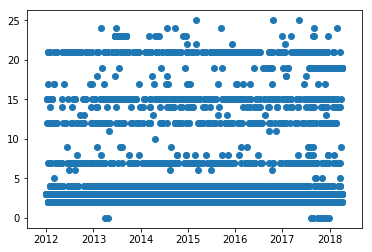

In [40]:
import matplotlib.pyplot as plt
plt.scatter(Master_df['SubmissionStatusDate'], Master_df['SubmissionClassCodeID'])
plt.show()


Next tasks

1.   Determine difference between approval date and submission date
2.   Create / select Data sets by submission class code
3.   Run model RFS test, see how it goes... ?


In [41]:
Original_df = Master_df.loc[Master_df['SubmissionType'] == 0, ['ApplNo', 'SubmissionStatusDate']]
Original_df = Original_df.rename(columns={"SubmissionStatusDate": "OriginalSubDate"})
Original_df

,ApplNo,OriginalSubDate
Index,,
60001,21746,2012-03-06
60713,21876,2013-04-08
60790,21883,2014-05-23
61080,21936,2014-09-24
61178,21951,2012-05-25
61647,22018,2017-03-17
61924,22063,2017-06-20
62314,22141,2018-02-28
62315,22142,2018-03-22


In [0]:
#list(Master_df.columns)
#list(Original_df.columns)
list(Original_df.header()

In [33]:
Master_df.head()

,ApplNo,OriginalSubDate_x,OriginalSubDate_y,OriginalSubDate_x,OriginalSubDate_y,SubmissionClassCodeID,SubmissionType,SubmissionNo,SubmissionStatus,SubmissionStatusDate,SubmissionsPublicNotes,ReviewPriority,ApplType,ApplPublicNotes,SponsorName,Elapsed_days
0,21746,2012-03-06,2012-03-06,2012-03-06,2012-03-06,7,0,1,AP,2012-03-06,0,0,0,0.0,WINDTREE THERAP,0.0
1,21746,2012-03-06,2012-03-06,2012-03-06,2012-03-06,4,1,1,AP,2012-12-19,0,0,0,0.0,WINDTREE THERAP,288.0
2,21746,2012-03-06,2012-03-06,2012-03-06,2012-03-06,4,1,2,AP,2013-04-10,0,0,0,0.0,WINDTREE THERAP,400.0
3,21746,2012-03-06,2012-03-06,2012-03-06,2012-03-06,4,1,3,AP,2013-10-03,0,0,0,0.0,WINDTREE THERAP,576.0
4,21746,2012-03-06,2012-03-06,2012-03-06,2012-03-06,4,1,4,AP,2014-04-03,0,0,0,0.0,WINDTREE THERAP,758.0


In [0]:
Master_df = Original_df.merge(Master_df, on="ApplNo", how='right')
Master_df['Elapsed_days']= (Master_df['SubmissionStatusDate'] - Master_df['OriginalSubDate']).dt.days
#Master_df.count_value(Master_df['SponsorName'])

In [43]:
pd.Series(Master_df['SponsorName']).value_counts()

0                               541
NOVARTIS                        456
PFIZER                          335
JANSSEN PHARMS                  327
ABBVIE                          312
MERCK SHARP DOHME               277
LILLY                           269
PHARMACIA AND UPJOHN            261
BOEHRINGER INGELHEIM            234
BAXTER HLTHCARE                 233
ALLERGAN SALES LLC              233
SANOFI AVENTIS US               226
BAYER HLTHCARE                  216
NOVARTIS PHARMS CORP            201
BRISTOL MYERS SQUIBB            197
GLAXOSMITHKLINE                 165
ASTRAZENECA PHARMS              148
GILEAD SCIENCES INC             146
HOSPIRA                         142
PF PRISM CV                     138
UCB INC                         137
WYETH PHARMS INC                134
NOVO NORDISK INC                122
GENENTECH                       122
TAKEDA PHARMS USA               120
APIL                            113
VIIV HLTHCARE                   110
EMD SERONO                  

To do - need to reformat the elapsed days into a list associated with each original application. 

In [44]:
#Master_df.SubmissionClassCodeID.describe()
pd.Series(Master_df['SubmissionClassCodeID']).value_counts()

3     6948
4     4761
2     1010
19     442
21     370
7      219
15     196
12     159
23      70
14      67
17      23
8       21
0       14
9       11
13       7
18       7
24       7
6        6
5        5
22       4
11       3
25       3
10       1
Name: SubmissionClassCodeID, dtype: int64

Create a subset of DF to test against ML
Need to bin the elapsed days

In [46]:
Testing_df = Master_df[['ApplNo', 'Elapsed_days', 'SubmissionClassCodeID', 'SubmissionType', 'SubmissionNo', 'ReviewPriority', 'ApplType']]
Testing_df.head()
Testing_df = Testing_df.drop(84, axis=0)
Testing_df = Testing_df.drop(1139, axis=0)
Testing_df = Testing_df.drop(2122, axis=0)
Testing_df.fillna(0, inplace = True)
Testing_df[Testing_df.Elapsed_days.astype(int) < 0]

,ApplNo,Elapsed_days,SubmissionClassCodeID,SubmissionType,SubmissionNo,ReviewPriority,ApplType


Bining the data in large buckets - 
pd.cut(np.array([1, 7, 5, 4, 6, 3]),
...        3, labels=["bad", "medium", "good"])
[bad, good, medium, medium, good, bad]
Categories (3, object): [bad < medium < good]

In [0]:
bins = [-1, 1, 100, 200, 400, 800, 1600, 3200]
labels = [0, 1, 2, 3, 4, 5, 6]
Testing_df['Binned'] = pd.cut(Testing_df['Elapsed_days'], bins=bins, labels=labels)

Start of the ML algorithm
Predictor Vars are the variables for us to play with down the line.

In [48]:
Testing_df.Binned.describe()


count     14351
unique        7
top           0
freq      12088
Name: Binned, dtype: int64

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Testing_df.fillna(0, inplace = True)

predictor_vars = ['ApplType', 'SubmissionType', 'SubmissionNo', 'ReviewPriority', 'SubmissionClassCodeID']
data, target = Testing_df[predictor_vars], Testing_df.Binned
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, random_state=0)

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
 

In [50]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))


              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3287
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         7
           3       0.41      0.41      0.41       123
           4       0.26      0.31      0.28       140
           5       0.06      0.40      0.11        30
           6       0.00      0.00      0.00         1

    accuracy                           0.86      3588
   macro avg       0.24      0.29      0.25      3588
weighted avg       0.92      0.86      0.89      3588



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#Start Here 



SubmissionClassCodeID	SubmissionClassCode	SubmissionClassCodeDescription

1	BIOEQUIV	Bioequivalence

2	EFFICACY	Efficacy

3	LABELING	Labeling

4	MANUF (CMC)	Manufacturing (CMC)

5	N/A	Not Applicable

6	S	Supplement

7	TYPE 1	Type 1 - New Molecular Entity

8	TYPE 1/4	Type 1 - New Molecular Entity and Type 4 - New Combination

9	TYPE 2	Type 2 - New Active Ingredient

10	TYPE 2/3	Type 2 - New Active Ingredient and Type 3 - New Dosage Form

11	TYPE 2/4	Type 2 New Active Ingredient and Type 4 New Combination

12	TYPE 3	Type 3 - New Dosage Form

13	TYPE 3/4	Type 3 - New Dosage Form and Type 4 - New Combination

14	TYPE 4	Type 4 - New Combination

15	TYPE 5	Type 5 - New Formulation or New Manufacturer

16	TYPE 6	Type 6 - New Indication (no longer used)

17	TYPE 7	Type 7 - Drug Already Marketed without Approved NDA

18	TYPE 8	Type 8 - Partial Rx to OTC Switch

19	UNKNOWN	

20	Unspecified	

21	REMS	REMS

22	TYPE 10	Type 10 - New Indication Submitted as Distinct NDA - Not Consolidated

23	MEDGAS	Medical Gas

24	TYPE 9	Type 9 - New Indication Submitted as Distinct NDA, Consolidated with Original NDA after Approval

25	TYPE 9- BLA	Type 9 - New indication submitted as distinct BLA, consolidated





In [0]:
list(Master_df.columns)

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)